In [118]:
# import os
# os.chdir('../')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.clustering_utils")
importlib.reload(imported_module)

<module 'utils.clustering_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/clustering_utils.py'>

In [71]:
# os.chdir('ekvlasova/tcr-covid-classifier')

In [21]:
old_beta = pd.read_csv('notebooks/old_beta.csv').drop(columns=['Unnamed: 0']).rename(columns={'0': 'cdr3aa'})

In [22]:
old_beta

,cdr3aa
0,CASSLGYEQYF
1,CASSLGGNQPQHF
2,CASSLGSNQPQHF
3,CASSLTGNTEAFF
4,CASSSSYEQYF
...,...
305,CASSQKGYEQYF
306,CASSMDRGYEQYF
307,CASRRTYEQYF
308,CASSRGWEQYF


In [6]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [7]:
beta_pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

<AxesSubplot:>

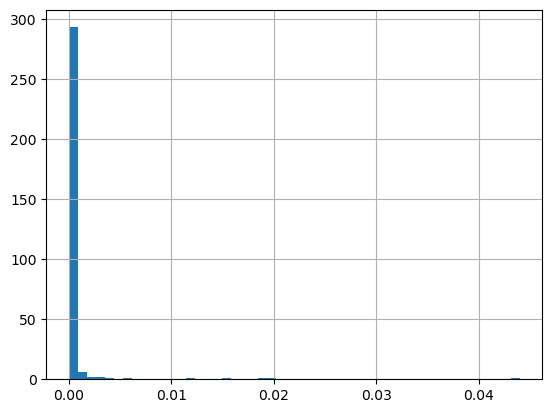

In [27]:
beta_pvals[beta_pvals.clone.isin(old_beta.cdr3aa)].pval.hist(bins=50)

In [32]:
beta_pvals[(beta_pvals.clone.isin(old_beta.cdr3aa)) & (beta_pvals.pval < 1e-6)]

,clone,pval
90342,CASRQGYEQYF,3.405890e-09
111746,CASSADSYEQYF,4.839813e-10
116864,CASSAGTGSYEQYF,3.493633e-07
117784,CASSAGYEQYF,7.873694e-09
126444,CASSASYEQYF,1.409516e-08
...,...,...
752689,CASSYDSYEQYF,1.915344e-11
756255,CASSYGGSYEQYF,1.383528e-08
759602,CASSYGTGSYEQYF,9.798225e-08
760382,CASSYGYEQYF,1.144189e-09


In [33]:
beta_pvals[beta_pvals.pval < 1e-6]

,clone,pval
17813,CASARGYEQYF,4.799746e-07
25268,CASGLGGSYEQYF,8.566854e-07
26190,CASGLSGGNQPQHF,6.003522e-09
90342,CASRQGYEQYF,3.405890e-09
102014,CASRTAYEQYF,7.223072e-08
...,...,...
897528,CSASDSYEQYF,2.970028e-07
898435,CSASGGGYEQYF,3.026567e-07
905190,CSASSGHEQYF,7.120231e-07
907031,CSATDLNTEAFF,5.898885e-07


In [9]:
#beta_pvals[beta_pvals.pval < 1e-5][['clone']].to_csv('data/covid_significant_clones_fmba_TRB_top_500k.csv', index=False)

In [126]:
res_beta = seqs2hamming(beta_pvals[beta_pvals.pval < 1e-5].clone, viz_method='graphopt')

In [127]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAISGQGVNTEAFF,0,-270.773436,-547.560214,1,-270.773436,-547.560214
1,CANSLGGSYEQYF,1,-133.134748,64.078145,212,14.768971,107.634820
2,CASSLGGSYEQYF,1,-39.349199,75.869732,212,14.768971,107.634820
3,CASAPGGSYEQYF,1,-80.096026,-37.849016,212,14.768971,107.634820
4,CASKPGGSYEQYF,1,-89.387189,-49.849054,212,14.768971,107.634820
...,...,...,...,...,...,...,...
658,CSASDRGYEQYF,74,-208.583409,-532.806280,1,-208.583409,-532.806280
659,CSASGGGYEQYF,75,-128.527151,574.355475,2,-118.516903,576.911178
660,CSASTGGYEQYF,75,-108.506656,579.466881,2,-118.516903,576.911178
661,CSATDLNTEAFF,76,-563.273722,-363.935750,1,-563.273722,-363.935750


In [128]:
res_beta[res_beta.cluster == 3]

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
358,CASGLGGNQPQHF,3,598.064011,-0.278157,14,556.26184,8.210885
359,CASSLGGNQPQHF,3,559.819901,0.798809,14,556.26184,8.210885
360,CASSLEGNQPQHF,3,585.642394,-26.958195,14,556.26184,8.210885
361,CASSLGFNQPQHF,3,544.831428,7.102155,14,556.26184,8.210885
362,CASSLGLNQPQHF,3,555.551534,36.948270,14,556.26184,8.210885
363,CASSLGMNQPQHF,3,565.163559,16.715040,14,556.26184,8.210885
364,CASSLGNNQPQHF,3,542.871653,36.692147,14,556.26184,8.210885
365,CASSLGPNQPQHF,3,548.385551,25.208942,14,556.26184,8.210885
366,CASSLGSNQPQHF,3,536.137417,15.107858,14,556.26184,8.210885
367,CASSLGTNQPQHF,3,563.870471,28.588012,14,556.26184,8.210885


In [129]:
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

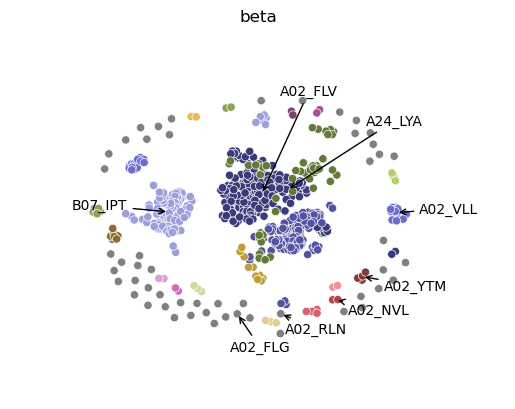

In [140]:
plot_clonotype_clustering_with_epitope_labeling(res_beta, 
                                                beta_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=650, 
                                                center_diff_threshold=75,
                                                )

plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title('beta')
plt.legend().set_visible(False)

In [72]:
alpha_pvals = pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

In [73]:
alpha_pvals[alpha_pvals.pval < 1e-4]

,clone,pval
354,CAAADNFNKFYF,9.144445e-09
607,CAAAFNKFYF,5.057810e-07
1685,CAAALYNFNKFYF,2.540847e-13
1732,CAAANAGNNRKLIW,7.172378e-05
1746,CAAANFNKFYF,3.867558e-24
...,...,...
1134227,RALSEAQGGSEKLVF,4.900306e-06
1134429,RALSSGSARQLTF,3.889343e-06
1134542,RALYNFNKFYF,1.493361e-10
1142371,YAALYNFNKFYF,1.922726e-09


In [134]:
res_alpha = seqs2hamming(alpha_pvals[alpha_pvals.pval < 1e-5].clone, viz_method='drl')

In [75]:
alpha_pvals[alpha_pvals.pval < 1e-5][['clone']].to_csv('data/covid_significant_clones_fmba_TRA_top_500k.csv', index=False)

In [135]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,19.140114,-65.720299,725,95.111894,-29.690036
1,CAAAYNFNKFYF,0,81.788292,29.251062,725,95.111894,-29.690036
2,CAAEDNFNKFYF,0,18.485338,-66.517731,725,95.111894,-29.690036
3,CAAGDNFNKFYF,0,20.176434,-67.226318,725,95.111894,-29.690036
4,CAAIDNFNKFYF,0,19.145973,-66.002838,725,95.111894,-29.690036
...,...,...,...,...,...,...,...
3489,CVVRNDSWGKLQF,88,-3.827184,-332.872742,6,-4.142760,-333.397669
3490,CVVRWDSWGKLQF,88,-4.476308,-333.275726,6,-4.142760,-333.397669
3491,CVVRYDSWGKLQF,88,-4.182046,-333.891083,6,-4.142760,-333.397669
3492,CVVSEPSGGYQKVTF,89,-363.702606,-103.023117,1,-363.702606,-103.023117


In [136]:
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA', alpha=0.05)

FLLNKEMYL
ALLSDLQDL


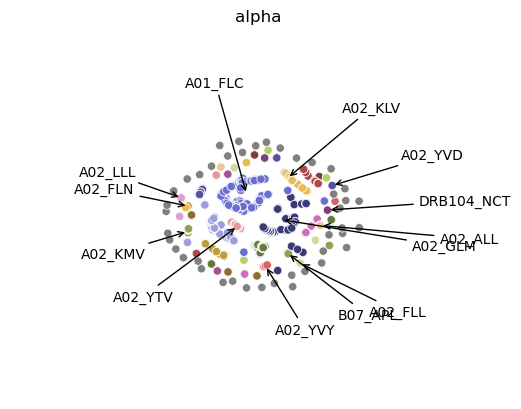

In [139]:
plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=650, 
                                                center_diff_threshold=75,
                                                )

plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.title('alpha')
plt.legend().set_visible(False)

In [138]:
for alpha_cluster in alpha_cluster_to_epi.keys():
    for beta_cluster in beta_cluster_to_epi.keys():
        if alpha_cluster_to_epi[alpha_cluster] is not None and beta_cluster_to_epi[beta_cluster] is not None and len(
            alpha_cluster_to_epi[alpha_cluster][['antigen.epitope']].merge(beta_cluster_to_epi[beta_cluster][['antigen.epitope']])) > 0:
            
            print(alpha_cluster, beta_cluster)
            print(alpha_cluster_to_epi[alpha_cluster][['antigen.epitope', 'antigen.species']].merge(
                beta_cluster_to_epi[beta_cluster][['antigen.epitope', 'antigen.species']]))

0 1
  antigen.epitope antigen.species
0       LLWNGPMAV             YFV
0 7
  antigen.epitope antigen.species
0       FTSDYYQLY      SARS-CoV-2
2 7
  antigen.epitope antigen.species
0   PKYVKQNTLKLAT      InfluenzaA
3 1
  antigen.epitope antigen.species
0       LLWNGPMAV             YFV
3 10
  antigen.epitope antigen.species
0      KRWIIMGLNK           HIV-1
9 2
   antigen.epitope antigen.species
0  PGVLLKEFTVSGNIL     HomoSapiens
17 3
  antigen.epitope antigen.species
0       LTDEMIAQY      SARS-CoV-2
17 7
  antigen.epitope antigen.species
0       LTDEMIAQY      SARS-CoV-2
68 1
  antigen.epitope antigen.species
0       YVDNSSLTI      SARS-CoV-2
